In [10]:
from TopoAnalysis import dem as d
import matplotlib.pylab as plt
from TopoAnalysis.plotting import plot_recursive_upstream_profiles
import numpy as np
import os
import pandas as pd

In [2]:
new_directory_path = "/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver"  
os.chdir(new_directory_path)
print("New working directory:", os.getcwd())

New working directory: /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver


In [26]:
outlets = {'rapel': {'RP-S2': [246249.2076, 6240448.447],
                    'RP-S3u': [250603.5211, 6228481.157],
                    'RP-S3': [250212.9354, 6237948.848],
                    'RP-S4u': [262281.9748, 6217862.614]}
          }

In [8]:
dem = d.Elevation.load('rapel_SRTMGL130m_dem_utm.tif')
print('dem loaded')
filled = d.Elevation.load('rapel_dem_utm_filled30m')
print('filled loaded')
area = d.Area.load('rapel_area_utm30m')
print('area loaded')
fd = d.FlowDirectionD8(flooded_dem = filled)
print('fd loaded')

dem loaded
filled loaded
area loaded
fd loaded


Figure saved to: /Users/Glong1/Desktop/Andes/AndesTG/Rapel/base_level/Figures/rapel_profiles.png


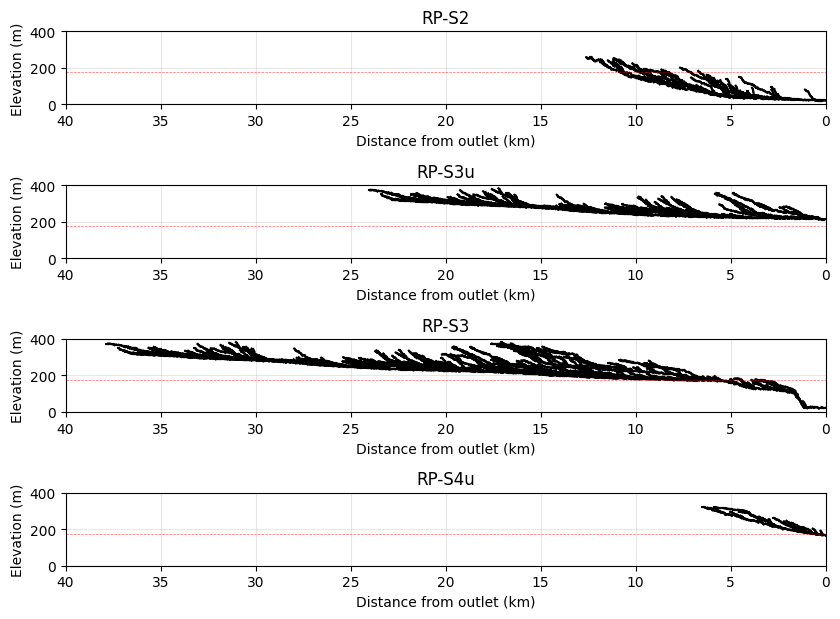

In [27]:
# Plotting all river profiles

def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance to next point
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer (sqrt(2) ≈ 1.414)
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Continue upstream
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Create figure with 4 subplots (one for each outlet)
fig, axs = plt.subplots(4, figsize=(8.5, 6.3))

for i, (outlet_name, outlet_coords) in enumerate(outlets['rapel'].items()):
    plt.sca(axs[i])
    
    # Get river network data
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    # Plot the profile
    plot_upstream_profile(ld_list, minimum_area=1E5)

    # Add dashed line at 175 m
    axs[i].axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Format the plot
    axs[i].set_xlim([40, 0])
    axs[i].set_ylim([0, 400])
    axs[i].grid(True, alpha=0.3)
    axs[i].set_xlabel('Distance from outlet (km)')
    axs[i].set_ylabel('Elevation (m)')
    axs[i].set_title(outlet_name)

plt.tight_layout()

# Save figure (set to where you want to save file)
save_dir = '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/base_level/Figures'
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'rapel_profiles.png')
plt.savefig(save_path)
print(f'Figure saved to: {os.path.abspath(save_path)}')
plt.show()

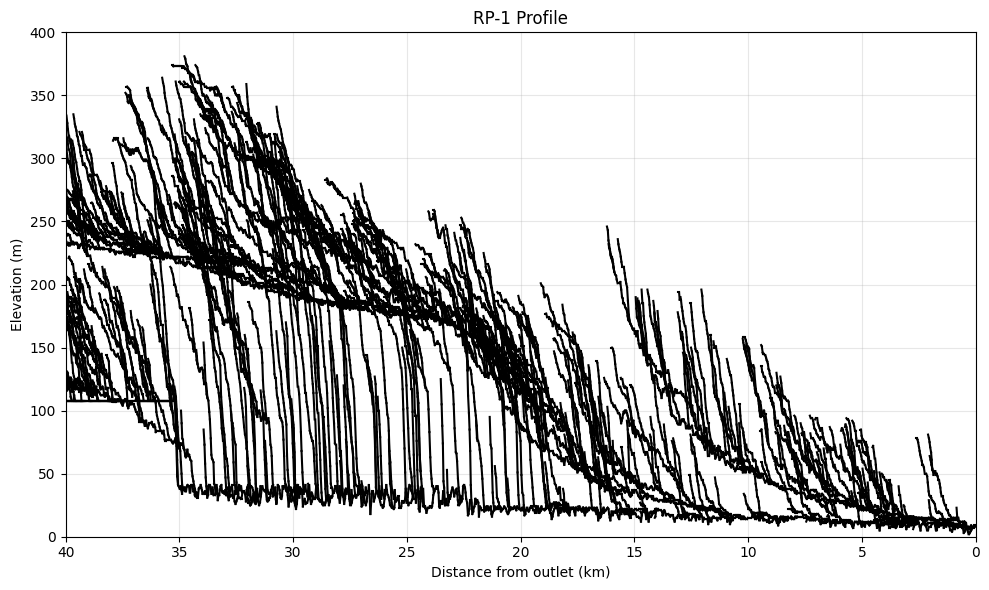

In [12]:
# Plots the river profile for point RP-1 at coordinates [240012.37420, 6244480.71900]

outlets = {
    'rapel': {
        'RP-1': [240012.37420, 6244480.71900]
    }
}

def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance to next point
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer (sqrt(2) ≈ 1.414)
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Continue upstream
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

outlet_coords = outlets['rapel']['RP-1']

# Get river network data
ld_list = fd.map_values_to_recursive_list(
    outlet_coords, 
    elevation=dem, 
    area=area, 
    de=mean_pixel_dimension
)
fix_indices_recursive(ld_list)

# Plot the profile
plot_upstream_profile(ld_list, minimum_area=1E5)

# Add dashed line at 175 m
axs[i].axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
axs[i].axhline(y=117, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

# Format the plot
ax.set_xlim([40, 0])
ax.set_ylim([0, 400])
ax.grid(True, alpha=0.3)
ax.set_xlabel('Distance from outlet (km)')
ax.set_ylabel('Elevation (m)')
ax.set_title('RP-1 Profile')

plt.tight_layout()

# Save figure
"""save_dir = 'Rapel/base_level/Figures'
os.makedirs(save_dir, exist_ok=True)
plt.savefig('Rapel/base_level/Figures/RP-1_profile.png')
print(f'Figure saved to: {os.path.abspath("Rapel/base_level/Figures/RP-1_profile.png")}')"""
plt.show()

In [31]:
outlets = {'rapel': {'6': [240424, 6244101],
                    '7': [239085, 6243561],
                    '8': [236433, 6241171],
                    '9': [234328, 6238328],
                    '10': [233535, 6235567],
                    '11': [224792, 6219641],
                    '12': [264468, 6205316],
                    '13': [266408, 6225311],
                    '14': [262741, 6227747],
                    '15': [261241, 6230944],
                    '16': [259484, 6233572],
                    '17': [253777, 6236472],
                    '18': [250409, 6238086],
                    '19': [248739, 6239914],
                    '20': [247017, 6241293],
                    '21': [239499, 6252555],
                    '22': [251995, 6254903],
                    '23': [256653, 6278345]}
          }

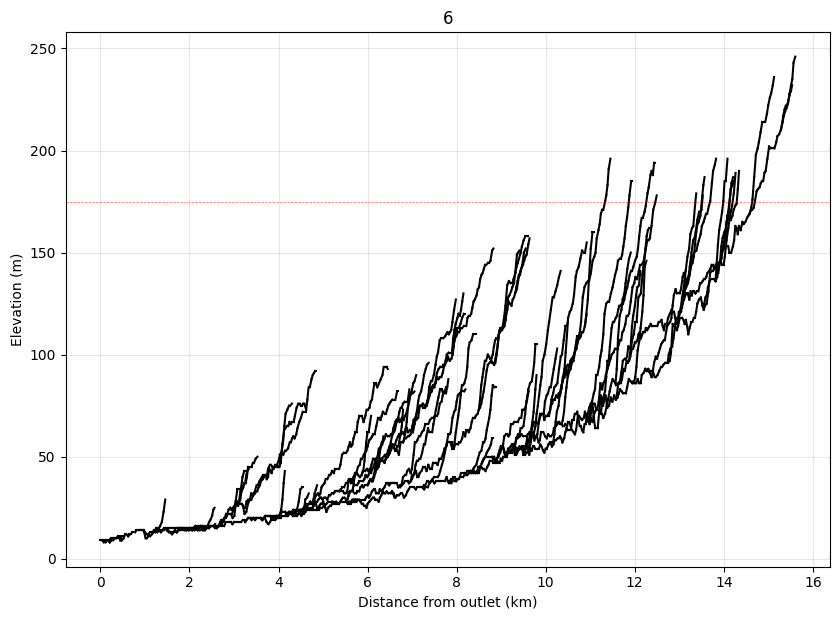

Plotted outlet: 6


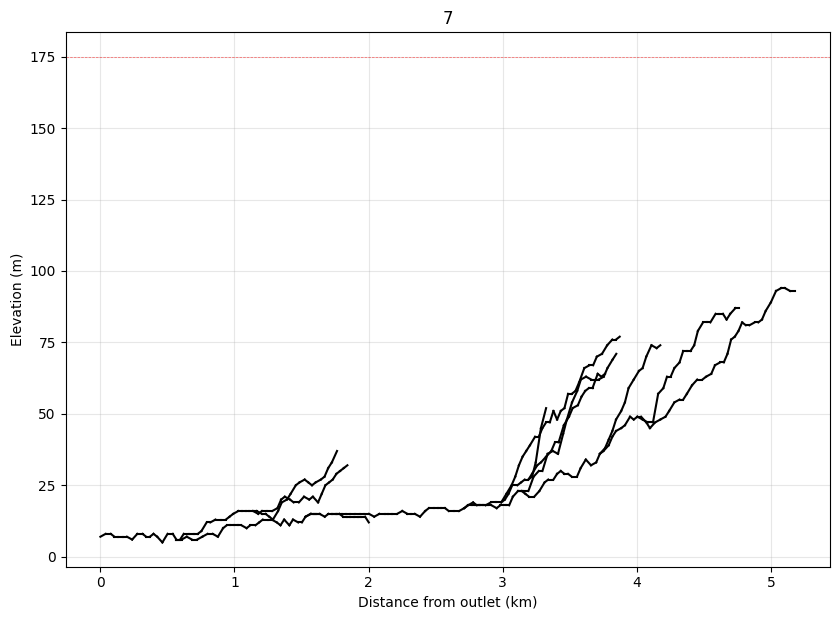

Plotted outlet: 7


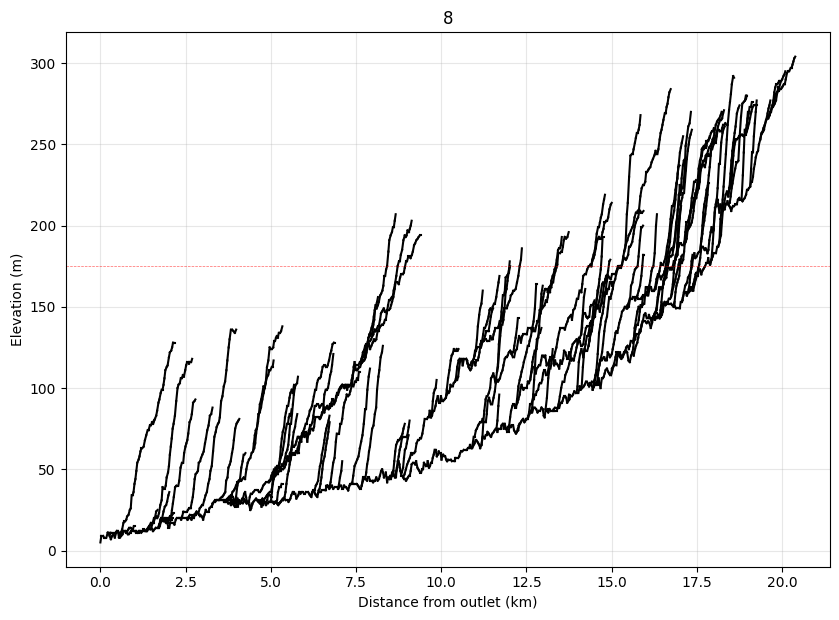

Plotted outlet: 8


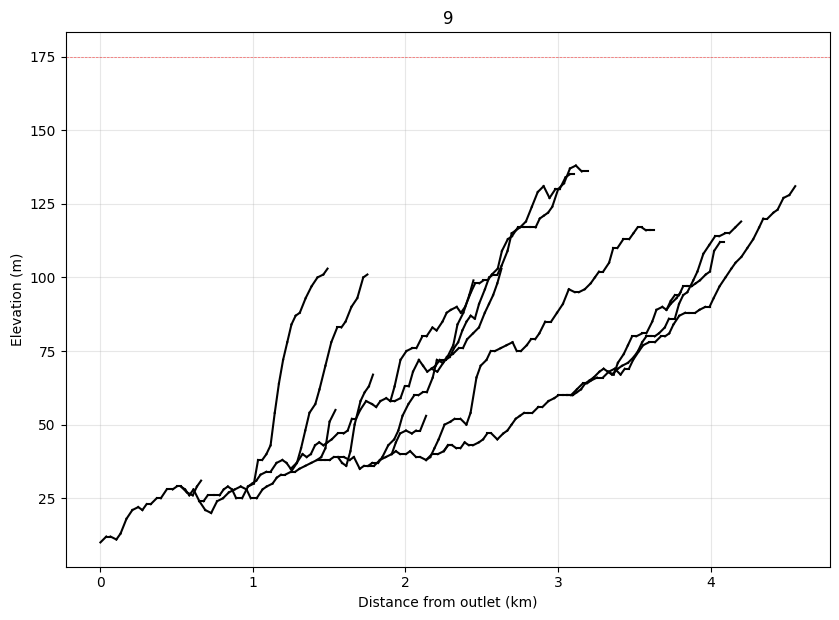

Plotted outlet: 9


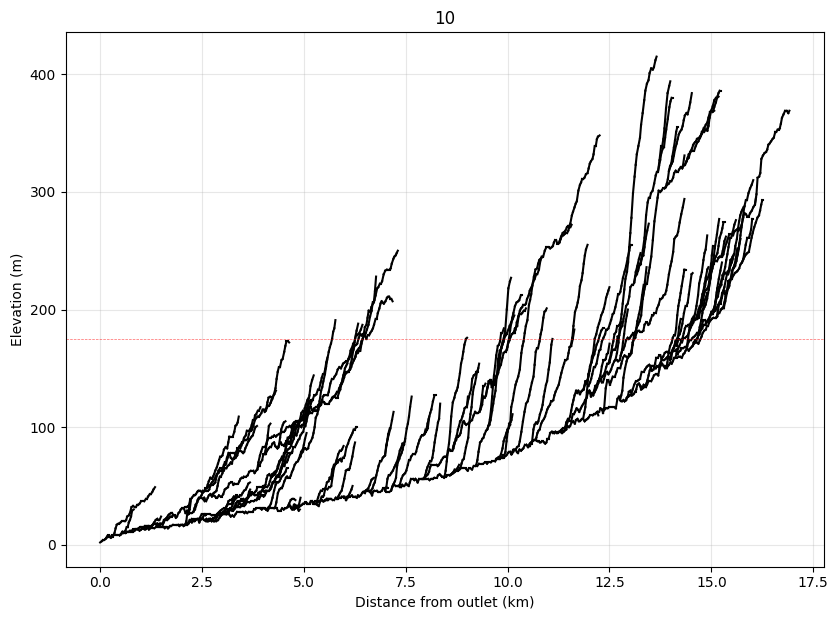

Plotted outlet: 10


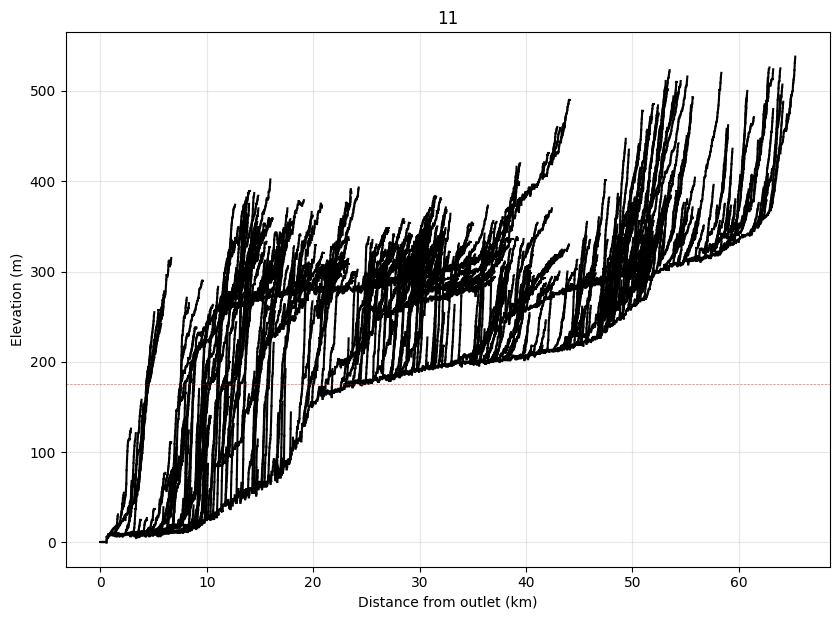

Plotted outlet: 11


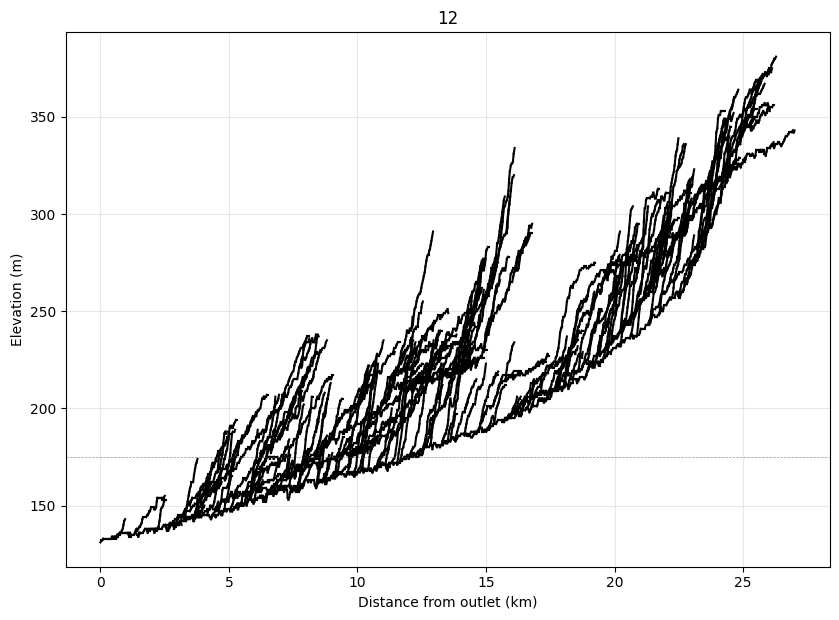

Plotted outlet: 12


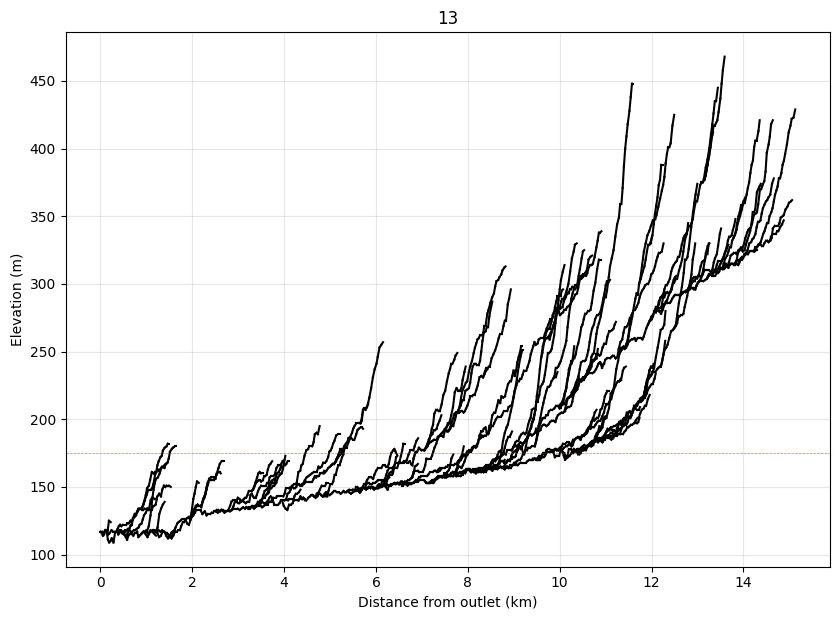

Plotted outlet: 13


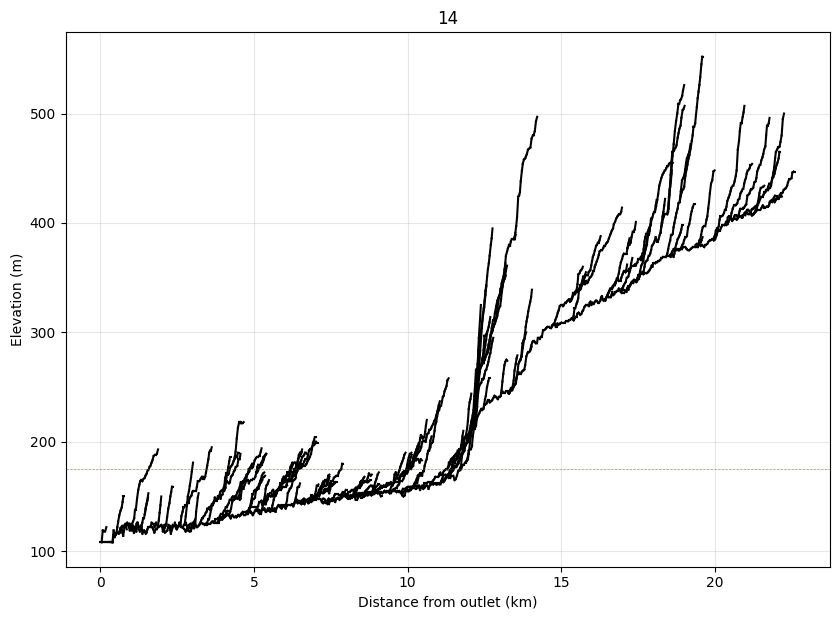

Plotted outlet: 14


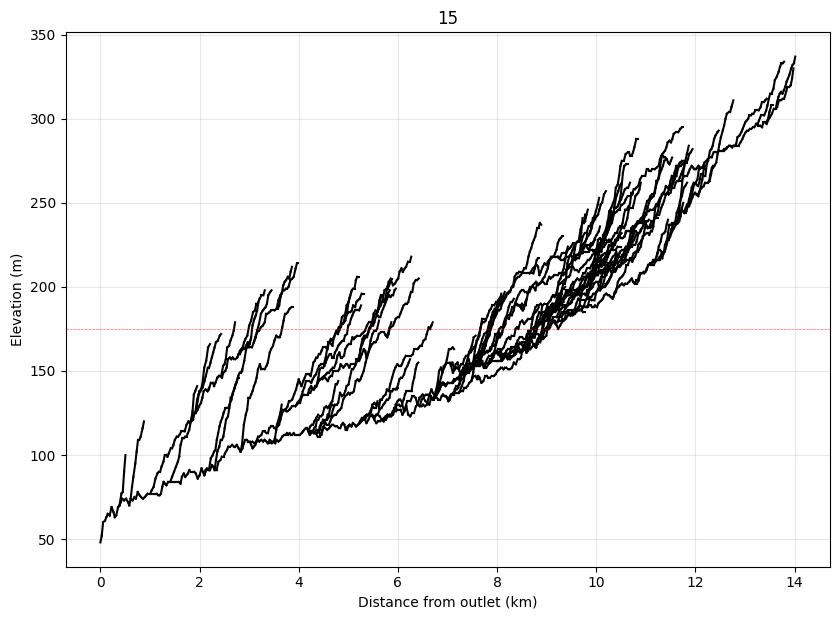

Plotted outlet: 15


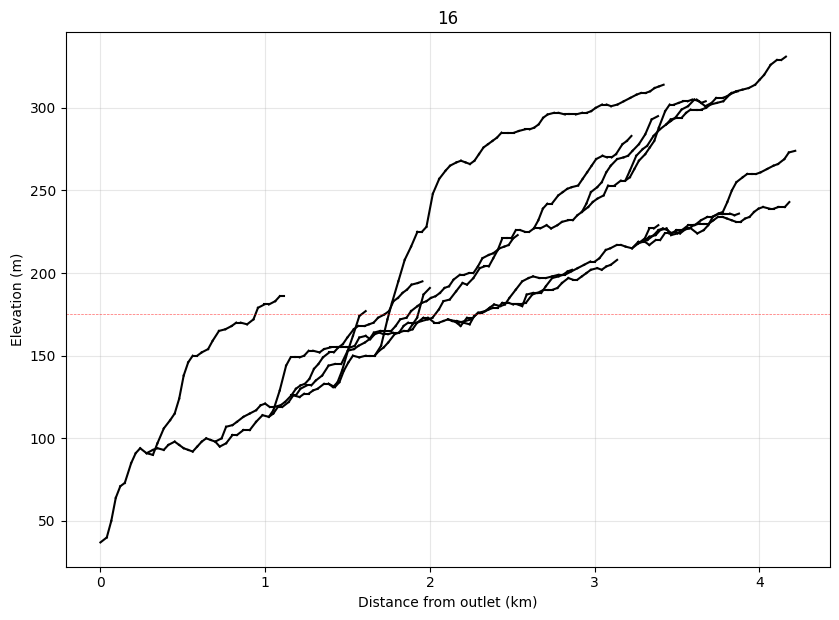

Plotted outlet: 16


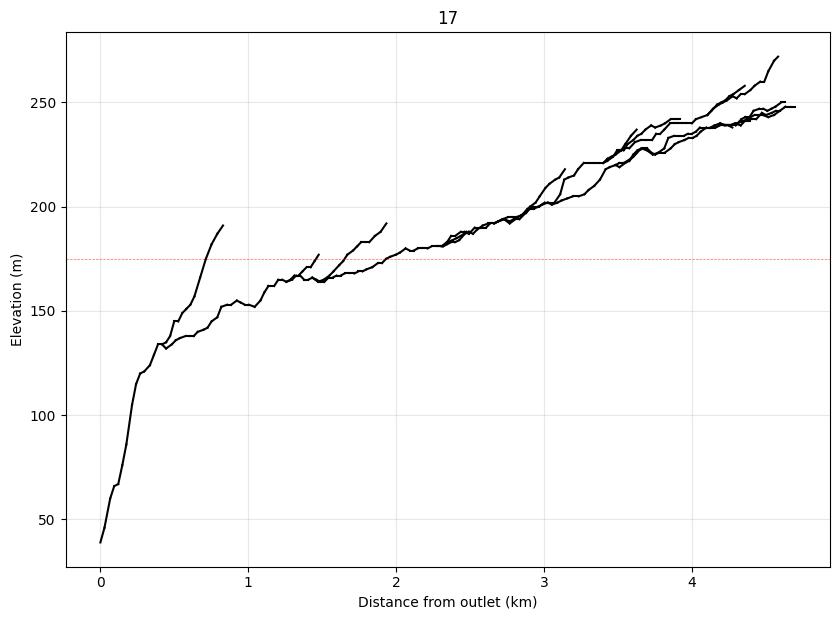

Plotted outlet: 17


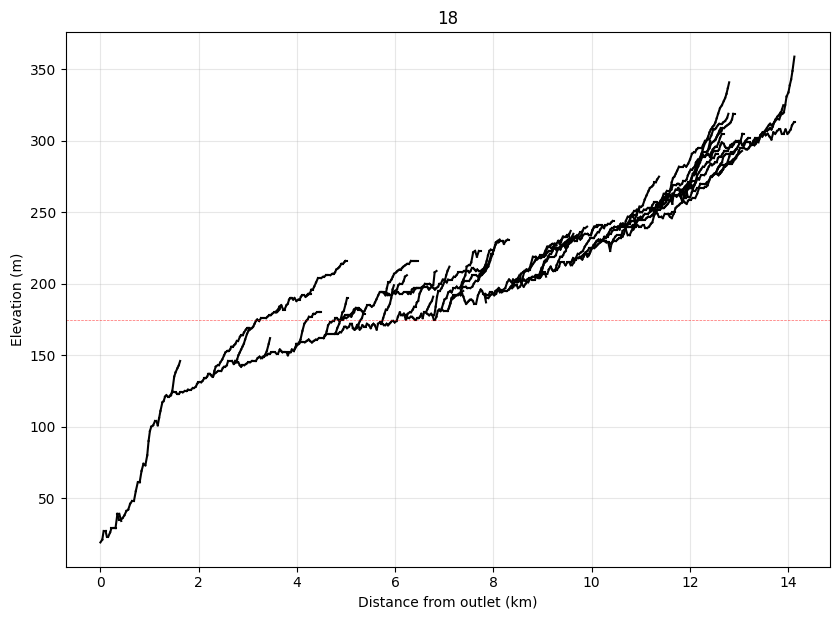

Plotted outlet: 18


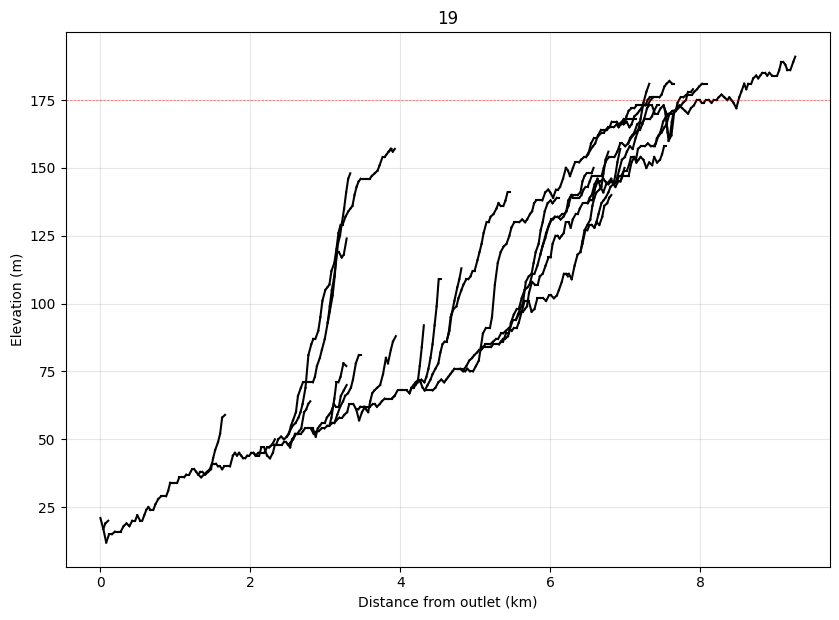

Plotted outlet: 19


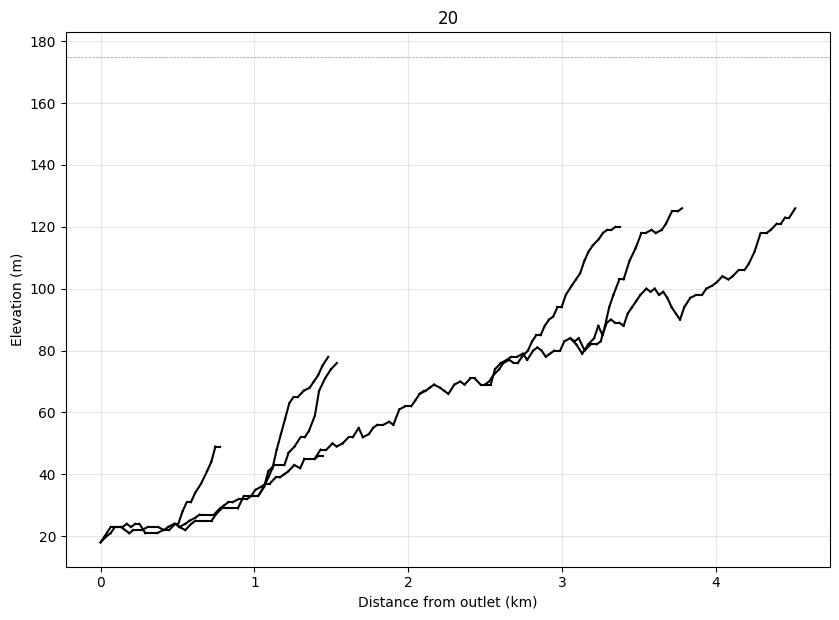

Plotted outlet: 20


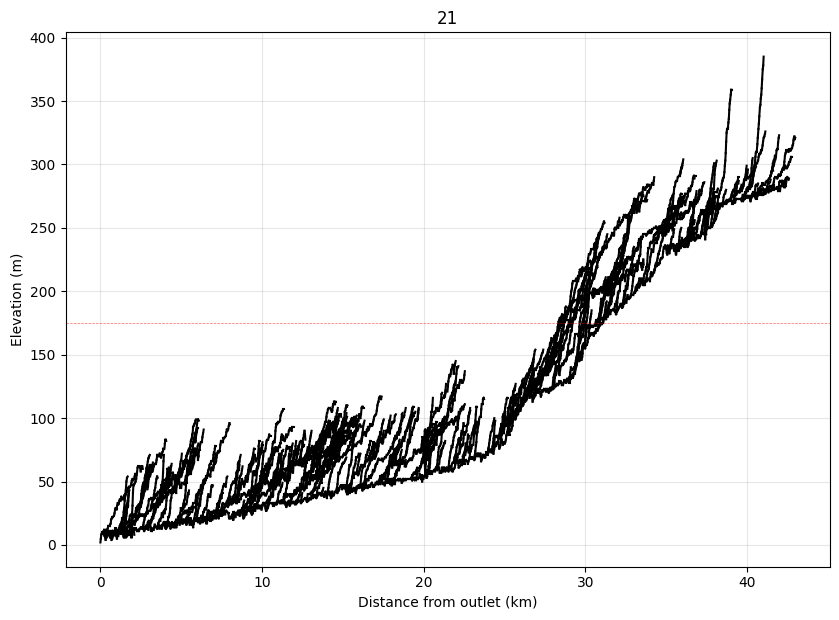

Plotted outlet: 21


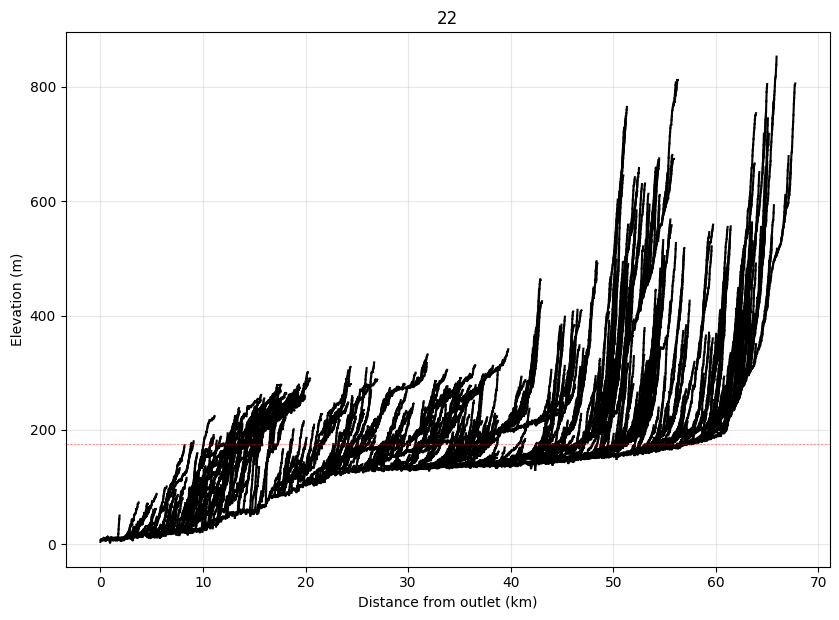

Plotted outlet: 22


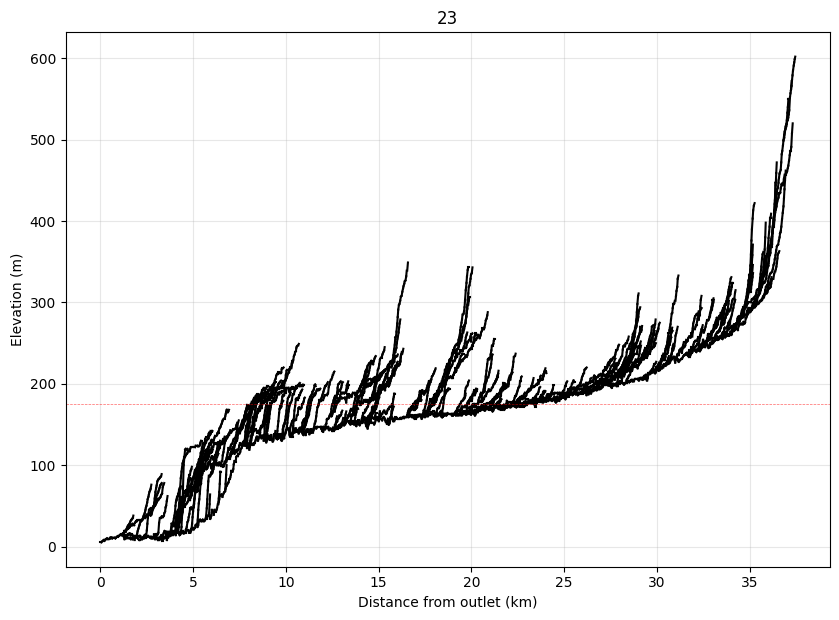

Plotted outlet: 23


In [35]:
# Plotting all river profiles
def fix_indices_recursive(ld_item):
    """Fix malformed indices if they're wrapped in a tuple"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot river profile moving upstream"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance to next point
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    # Diagonal movement is longer (sqrt(2) ≈ 1.414)
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance + distance_increment
                    
                    # Draw line segment (convert meters to km)
                    plt.plot([current_distance/1000, next_distance/1000], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Continue upstream
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

# Setup mean pixel dimension
mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Plot each outlet separately
for outlet_name, outlet_coords in outlets['rapel'].items():
    fig, ax = plt.subplots(1, figsize=(8.5, 6.3))
    
    # Get river network data
    ld_list = fd.map_values_to_recursive_list(
        outlet_coords, 
        elevation=dem, 
        area=area, 
        de=mean_pixel_dimension
    )
    fix_indices_recursive(ld_list)
    
    # Plot the profile
    plot_upstream_profile(ld_list, minimum_area=1E5)
    
    # Add dashed line at 175 m
    ax.axhline(y=175, color='red', linestyle='--', linewidth=0.5, alpha=0.6)
    
    # Format the plot
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Distance from outlet (km)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title(outlet_name)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Plotted outlet: {outlet_name}')